In [73]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from tqdm import tqdm

### Configuration

In [74]:
DATA_DIR="../data/cluster/UP000005640_9606/"
PROTEOME_NAME="UP000005640_9606"

In [75]:
PLDDT_SCORES_JSON=os.path.join(DATA_DIR,f"{PROTEOME_NAME}_HUMAN_v3_plddts_fltrd.json")
SETH_SCORES_FASTA=os.path.join(DATA_DIR,"Human_SETH_preds.txt")
NEFF_GPU_SCORES_JSON=os.path.join(DATA_DIR,f"{PROTEOME_NAME}_neff_fast.json")
NEFF_MMSEQS_SCORES_JSON=os.path.join(DATA_DIR,f"{PROTEOME_NAME}_neff_mmseqs.json")
NEFF_HHSUITE_SCORES_DIR=os.path.join(DATA_DIR,f"{PROTEOME_NAME}_neff_hhsuite.json")
NEFF_NAIVE_SCORES_DIR=os.path.join(DATA_DIR,f"{PROTEOME_NAME}_neff_naive.json")

In [76]:
colors = sns.color_palette("colorblind")
colors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

### Load scores

Per-protein per-residue scores for each metric.

In [77]:
# load pLDDT scores
with open(PLDDT_SCORES_JSON) as f:
    plddt = json.load(f)
    plddt = {p:torch.tensor(xs) for p,xs in plddt.items()}
print(len(plddt), "plddt scores loaded")

20296 plddt scores loaded


In [78]:
# load SETH scores
with open(SETH_SCORES_FASTA) as f:
    seth = {}
    lines = f.readlines()
    for hdr,scores in zip(lines[::2],lines[1::2]):
        hdrid=hdr.split("|")[1]
        score=torch.tensor([float(s) for s in scores.split(", ")])
        seth[hdrid]=score
print(len(seth), "SETH scores loaded")

20352 SETH scores loaded


In [79]:
# load Neff gpu scores
with open(NEFF_GPU_SCORES_JSON) as f:
    neff_gpu = json.load(f)
    neff_gpu = {p:torch.tensor(xs) for p,xs in neff_gpu.items()}
print(len(neff_gpu), "neff gpu scores loaded")

18741 neff gpu scores loaded


In [80]:
# load Neff mmseqs scores
with open(NEFF_MMSEQS_SCORES_JSON) as f:
    neff_mmseqs = json.load(f)
    neff_mmseqs = {p:torch.tensor(xs) for p,xs in neff_mmseqs.items()}
print(len(neff_mmseqs), "neff mmseqs scores loaded")

20600 neff mmseqs scores loaded


In [81]:
# load Neff hhsuite scores
with open(NEFF_HHSUITE_SCORES_DIR) as f:
    neff_hhsuite = json.load(f)
    neff_hhsuite = {p:torch.tensor(xs) for p,xs in neff_hhsuite.items()}
print(len(neff_hhsuite), "neff hhsuite scores loaded")

20599 neff hhsuite scores loaded


In [82]:
# load Neff naive scores
with open(NEFF_NAIVE_SCORES_DIR) as f:
    neff_naive = json.load(f)
    neff_naive = {p:torch.tensor(xs) for p,xs in neff_naive.items()}
print(len(neff_naive), "neff naive scores loaded")

14477 neff naive scores loaded


### Find consistent proteins

Only correlate metrics for which we have data for all proteins. Data means that every dataset contains the protein and the proteins have the same lengths across all datasets.

In [83]:
shared_ids = set(plddt) & set(seth) & set(neff_gpu) & set(neff_mmseqs) & set(neff_hhsuite) & set(neff_naive)
print("found", len(shared_ids), "ids that are present in all datasets")

found 13886 ids that are present in all datasets


In [84]:
lenagree_ids = []
for protid in shared_ids:
    if len(plddt[protid]) == len(seth[protid]) == len(neff_gpu[protid]) == len(neff_mmseqs[protid]) == len(neff_hhsuite[protid]) == len(neff_naive[protid]):
        lenagree_ids.append(protid)
print("found", len(lenagree_ids), "proteins with agreeing lengths")

found 13848 proteins with agreeing lengths


In [85]:
# only retain scores that are present in all 3 datasets for convinience
ids = lenagree_ids
plddt = {p:xs for p,xs in plddt.items() if p in ids}
seth = {p:xs for p,xs in seth.items() if p in ids}
neff_gpu = {p:xs for p,xs in neff_gpu.items() if p in ids}
neff_mmseqs = {p:xs for p,xs in neff_mmseqs.items() if p in ids}
neff_hhsuite = {p:xs for p,xs in neff_hhsuite.items() if p in ids}
neff_naive = {p:xs for p,xs in neff_naive.items() if p in ids}
len(neff_gpu),len(neff_mmseqs),len(seth),len(plddt),len(neff_hhsuite),len(neff_naive),len(ids)

(13848, 13848, 13848, 13848, 13848, 13848, 13848)

### Analysis

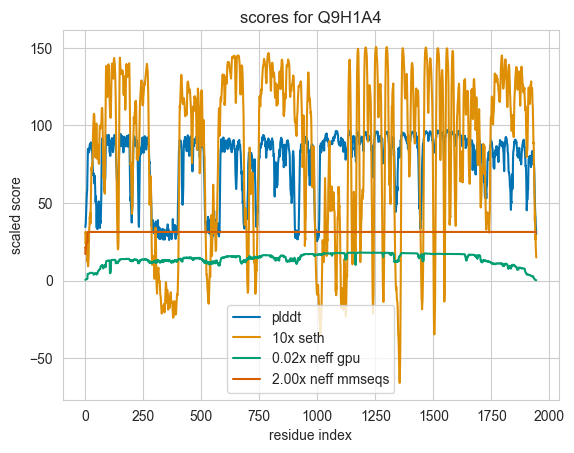

In [33]:
def showscores(protid,sethscale=10.,neff_gpu_scale=.02,neff_mmseqs_scale=2.):
    plt.plot(plddt[protid],label="plddt",color=colors[0])
    plt.plot(sethscale*seth[protid],label="%.0fx seth" % sethscale,color=colors[1])
    plt.plot(neff_gpu_scale*neff_gpu[protid],label="%.02fx neff gpu" % neff_gpu_scale,color=colors[2])
    plt.plot(neff_mmseqs_scale*neff_mmseqs[protid],label="%.02fx neff mmseqs" % neff_mmseqs_scale,color=colors[3])
    plt.xlabel("residue index")
    plt.ylabel("scaled score")
    plt.legend()
    plt.title("scores for %s" % protid)
testid = list(ids)[100]
showscores(testid)

In [104]:
corrs = {}
scores = {"plddt":plddt,"seth":seth,"neff gpu":neff_gpu,"neff mmseqs":neff_mmseqs,"neff hhsuite":neff_hhsuite, "neff naive":neff_naive}
score2id = {s:i for i,s in enumerate(scores.keys())}
id2score = {i:s for s,i in score2id.items()}
product_momentum_excluded = []
for protid in tqdm(ids,desc="calculating pairwise correlations"):
    st = torch.stack(tuple(score[protid] for score in scores.values()))
    # see if covariance matrix contains zero entries on the diagonal since
    # these would lead to nan entries in the correlation matrix.
    # here, these matrices are set to zeros because there is no variance.
    if len(torch.diag(torch.cov(st)).nonzero()) == len(scores):
        corrs[protid] = torch.corrcoef(st)
    else:
        product_momentum_excluded += [protid]
print("excluded",len(product_momentum_excluded),"proteins due to no variance:")
print(product_momentum_excluded)

calculating pairwise correlations: 100%|██████████| 13848/13848 [00:00<00:00, 16004.12it/s]

excluded 37 proteins due to no variance:
['Q9BTD1', 'Q8TCZ7', 'Q0VDD5', 'Q9BQT8', 'A0A0J9YWX3', 'J3KSC0', 'A0A075B700', 'Q0P140', 'Q96QG7', 'Q8IVK1', 'P20160', 'A0A075B6S0', 'Q8WZA8', 'Q15493', 'Q9P1D8', 'Q75NE6', 'A0A0B4J200', 'Q96IR3', 'Q0VG73', 'Q9H0P7', 'Q9UJ94', 'A0A0A0MTA7', 'P0C841', 'Q8TAB7', 'O43653', 'A0A0J9YXG5', 'A0A0C5B5G6', 'P0DP58', 'Q9HBX3', 'Q9Y3F1', 'Q9BVJ7', 'Q6IMI4', 'A0A0A0MT94', 'A0A0J9YWP8', 'Q96MF0', 'Q9BZS9', 'Q9GZZ1']


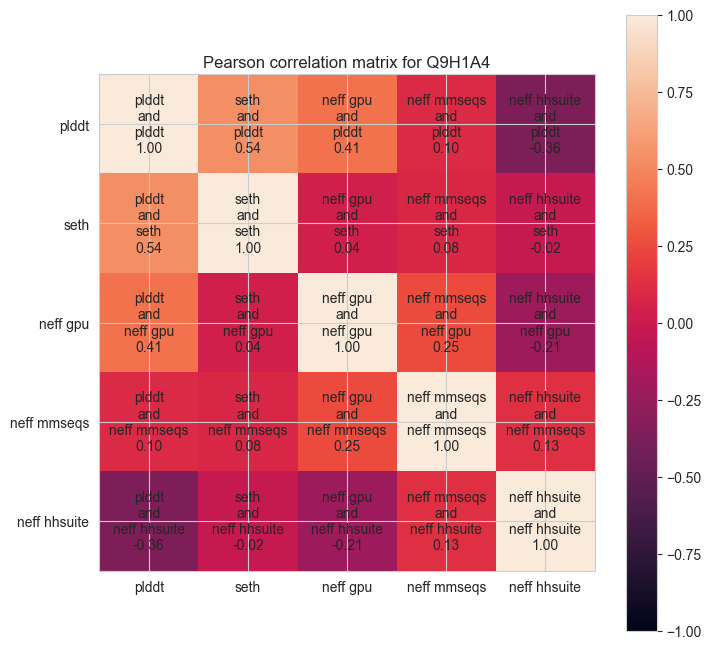

In [87]:
def showcorr(corrmat,name,prefix="",lims=(-1,1)):
    """show correlation between scores"""
    plt.figure(figsize=(8,8))
    plt.imshow(corrmat)
    plt.colorbar()
    plt.title("%sPearson correlation matrix for %s" % (prefix,name))
    plt.xticks(range(len(scores.keys())),scores.keys())
    plt.yticks(range(len(scores.keys())),scores.keys())
    if lims is not None:
        plt.clim(*lims)
    for x,l1 in enumerate(scores.keys()):
        for y,l2 in enumerate(scores.keys()):
            val = corrmat[x][y].item()
            plt.text(x,y,"%s\nand\n%s\n%.02f" % (l1,l2,val),ha="center",va="center")
showcorr(corrs[testid], name=testid)

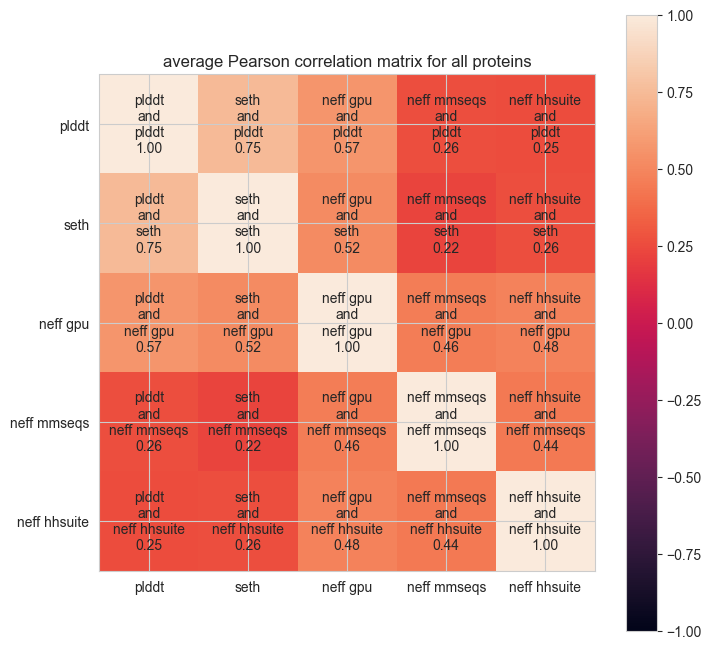

In [88]:
corrstack = torch.stack(tuple(corrs.values()))
corrstd, corravg = torch.std_mean(corrstack,dim=0)
showcorr(corravg, name="all proteins", prefix="average ")

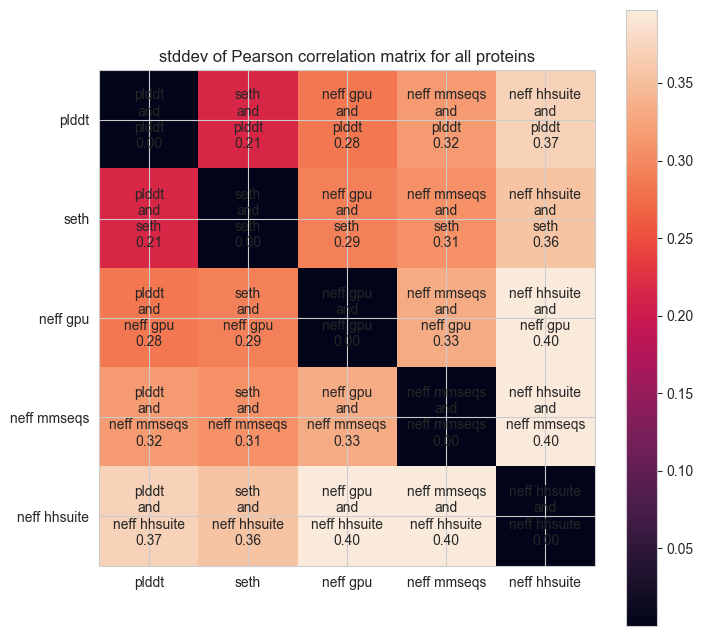

In [89]:
# TODO: why is the diagonal filled with .05???
showcorr(corrstd, name="all proteins", prefix="stddev of ", lims=None)

### Find outliers

In [90]:
neffid,plddtid = score2id["neff gpu"],score2id["plddt"]

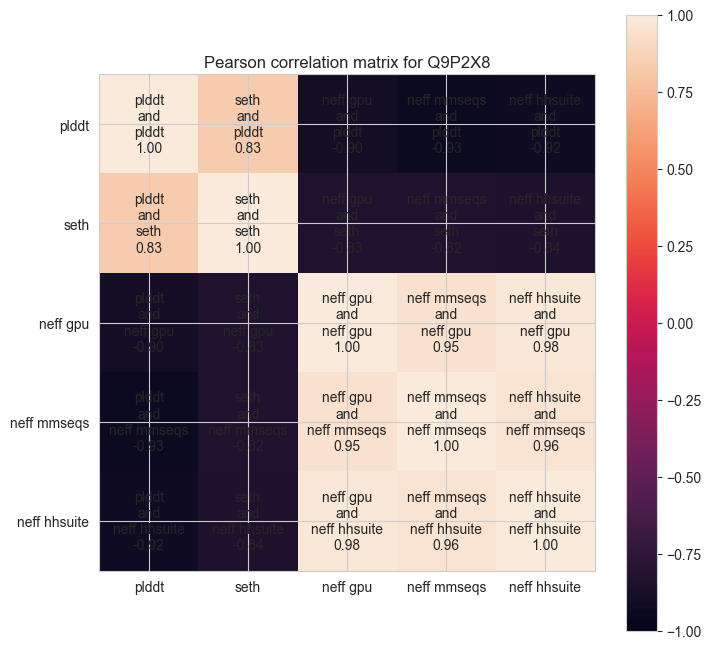

In [91]:
minid,minval = None,float("inf")
for protid in corrs:
    val = corrs[protid][neffid,plddtid].item()
    if minval > val:
        minval = val
        minid  = protid
showcorr(corrs[minid],minid)

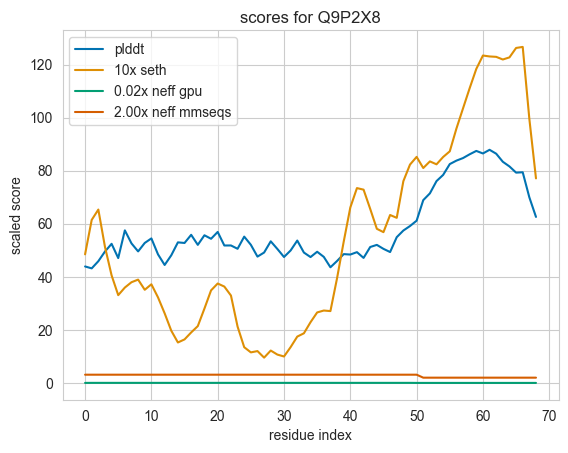

In [92]:
showscores(minid)

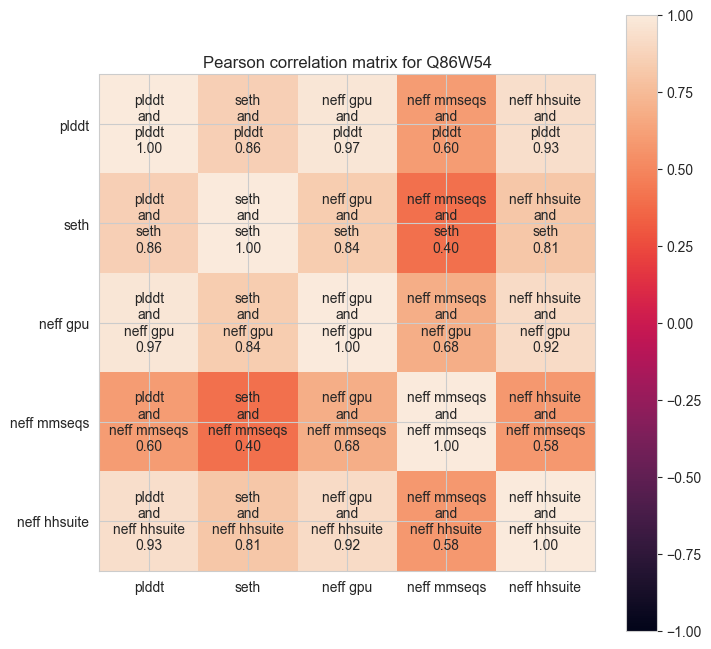

In [93]:
maxid,maxval = None,float("-inf")
for protid in corrs:
    val = corrs[protid][neffid,plddtid].item()
    if maxval < val:
        maxval = val
        maxid  = protid
showcorr(corrs[maxid],maxid)

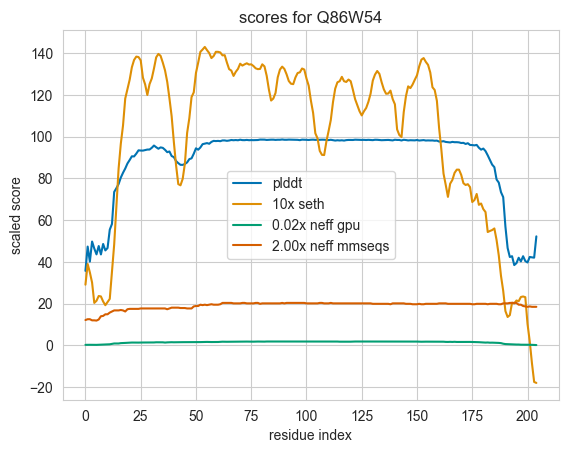

In [94]:
showscores(maxid)

### Bin scores

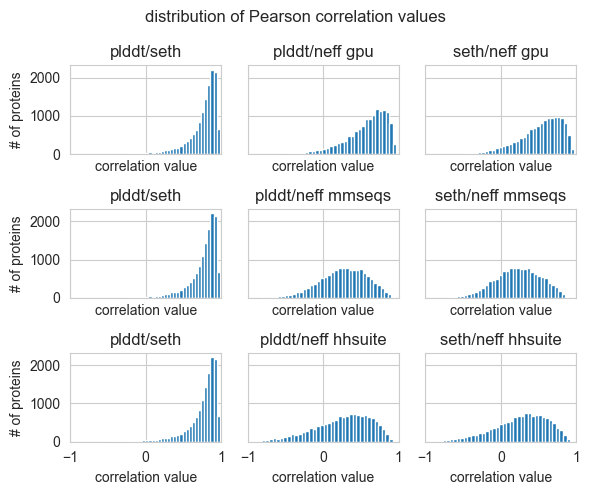

In [95]:
pairs = [
    [("plddt","seth"),("plddt","neff gpu"),("seth","neff gpu")],
    [("plddt","seth"),("plddt","neff mmseqs"),("seth","neff mmseqs")],
    [("plddt","seth"),("plddt","neff hhsuite"),("seth","neff hhsuite")],
    [("plddt","seth"),("plddt","neff naive"),("seth","neff naive")],
]
idpairs = [[(score2id[s1],score2id[s1]) for s1,s2 in p] for p in pairs]
fig,axss = plt.subplots(ncols=len(pairs[0]),nrows=3,figsize=(6,5),sharey=True,sharex=True)
for rowidx,r in enumerate(["neff gpu","neff mmseqs","neff hhsuite"]):
    axs = axss[rowidx]
    for colidx,(ax,p) in enumerate(zip(axs,pairs[rowidx])):
        if colidx == 0:
            ax.set_ylabel("# of proteins")
        
        s1,s2 = p
        id1,id2 = score2id[s1],score2id[s2]

        ax.hist(corrstack[:,id1,id2].sort()[0],bins=40)
        ax.set_title("%s/%s" % p)
        ax.set_xlabel("correlation value")
        ax.set_xlim(-1,1)
fig.suptitle("distribution of Pearson correlation values")
fig.tight_layout()

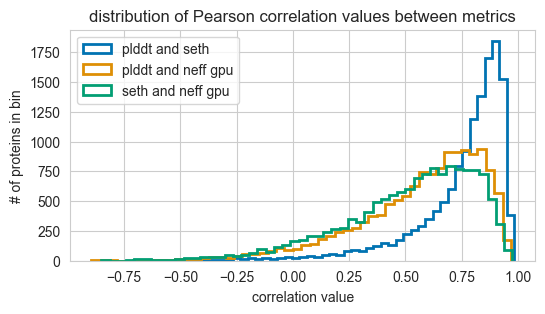

In [96]:
pairs = [("plddt","seth"),("plddt","neff gpu"),("seth","neff gpu")]
plt.figure(figsize=(6,3))
for i,(ax,p) in enumerate(zip(axs,pairs)):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    plt.hist(corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=colors[i])
#plt.axvline(0,label="no correlation",c="k",ls=":")
plt.xlabel("correlation value")
plt.ylabel("# of proteins in bin")
plt.title("distribution of Pearson correlation values between metrics")
plt.legend(loc="upper left");

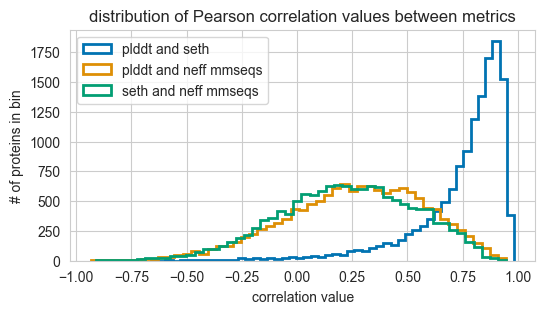

In [97]:
pairs = [("plddt","seth"),("plddt","neff mmseqs"),("seth","neff mmseqs")]
plt.figure(figsize=(6,3))
for i,(ax,p) in enumerate(zip(axs,pairs)):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    plt.hist(corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=colors[i])
#plt.axvline(0,label="no correlation",c="k",ls=":")
plt.xlabel("correlation value")
plt.ylabel("# of proteins in bin")
plt.title("distribution of Pearson correlation values between metrics")
plt.legend(loc="upper left");

### More thorough analysis

In [98]:
from scipy import stats
import warnings
from collections import defaultdict
PTHRESH = .05 # Pearson p-value threshold (everything above is discarded)

In [105]:
pearson_corrs, pearson_pvalues = {}, {}
excluded = []
high_pvalues,constant_input = 0,0
per_score_low_pvalues = defaultdict(lambda: 0)
prot2highpcount = defaultdict(lambda: 0)
prot2constcount = defaultdict(lambda: 0)
for protid in tqdm(ids,desc="calc'ing Pearson corr"):
    prot_pvalues = torch.zeros((len(scores),)*2)
    prot_corrs = torch.zeros((len(scores),)*2)
    error = False
    for idx1, (score_name1, score1) in enumerate(scores.items()):
        for idx2, (score_name2, score2) in enumerate(scores.items()):
            with warnings.catch_warnings():
                warnings.filterwarnings("error")
                try:
                    res = stats.pearsonr(score1[protid], score2[protid])
                except stats.ConstantInputWarning as e:
                    error = True
                    constant_input += 1
                    prot2constcount[protid] += 1
                else:
                    prot_pvalues[idx1,idx2] = res.pvalue
                    prot_corrs[idx1,idx2] = res.statistic
                    if res.pvalue > PTHRESH:
                        high_pvalues += 1
                        prot2highpcount[protid] += 1
                        per_score_low_pvalues[(score_name1,score_name2)] += 1
                        error = True
    if not error:
        pearson_corrs[protid] = prot_corrs
        pearson_pvalues[protid] = prot_pvalues
    else:
        excluded += [protid]

calc'ing Pearson corr: 100%|██████████| 13848/13848 [00:18<00:00, 758.38it/s]


In [106]:
print("excluded", len(excluded), "proteins due to no variance or too high pvalue")
print(f"{high_pvalues/(len(scores)**2)=}")
print(f"{constant_input/(len(scores)**2)=}")
print("retained",len(pearson_corrs),"proteins")
per_score_low_pvalues

excluded 7364 proteins due to no variance or too high pvalue
high_pvalues/(len(scores)**2)=985.4444444444445
constant_input/(len(scores)**2)=37.916666666666664
retained 6484 proteins


defaultdict(<function __main__.<lambda>()>,
            {('neff hhsuite', 'neff naive'): 1048,
             ('neff naive', 'neff hhsuite'): 1048,
             ('neff gpu', 'neff mmseqs'): 1058,
             ('neff mmseqs', 'neff gpu'): 1058,
             ('neff mmseqs', 'neff naive'): 1146,
             ('neff naive', 'neff mmseqs'): 1146,
             ('plddt', 'neff hhsuite'): 1948,
             ('seth', 'neff gpu'): 906,
             ('neff gpu', 'seth'): 906,
             ('neff hhsuite', 'plddt'): 1948,
             ('seth', 'neff hhsuite'): 2011,
             ('neff hhsuite', 'seth'): 2011,
             ('seth', 'neff naive'): 785,
             ('neff naive', 'seth'): 785,
             ('plddt', 'neff mmseqs'): 2260,
             ('neff mmseqs', 'plddt'): 2260,
             ('seth', 'neff mmseqs'): 2613,
             ('neff mmseqs', 'seth'): 2613,
             ('neff mmseqs', 'neff hhsuite'): 1288,
             ('neff hhsuite', 'neff mmseqs'): 1288,
             ('neff gpu', 'nef

In [107]:
len([protid for protid,count in prot2highpcount.items() if count > 0])

7320

In [108]:
len([protid for protid,count in prot2constcount.items() if count > 0])

90

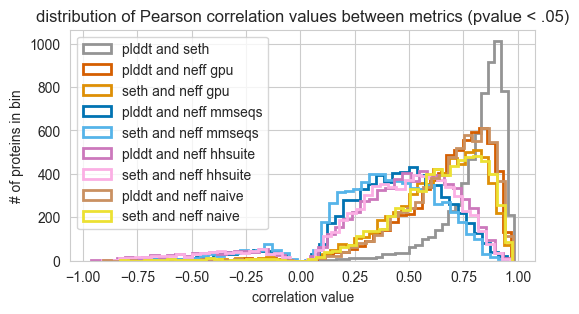

In [112]:
pairs = {
    ("plddt","seth"):colors[-3],
    ("plddt","neff gpu"):colors[3],("seth","neff gpu"):colors[1],
    ("plddt","neff mmseqs"):colors[0],("seth","neff mmseqs"):colors[-1],
    ("plddt","neff hhsuite"):colors[4],("seth","neff hhsuite"):colors[6],
    ("plddt","neff naive"):colors[5],("seth","neff naive"):colors[8],
}
plt.figure(figsize=(6,3))
pearson_corrstack = torch.stack(tuple(pearson_corrs.values()))
for i,(p,c) in enumerate(pairs.items()):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    # c=colors[i]
    plt.hist(pearson_corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=c)
#plt.axvline(0,label="no correlation",c="k",ls=":")
plt.xlabel("correlation value")
plt.ylabel("# of proteins in bin")
plt.title("distribution of Pearson correlation values between metrics (pvalue < .05)")
plt.legend(loc="upper left");

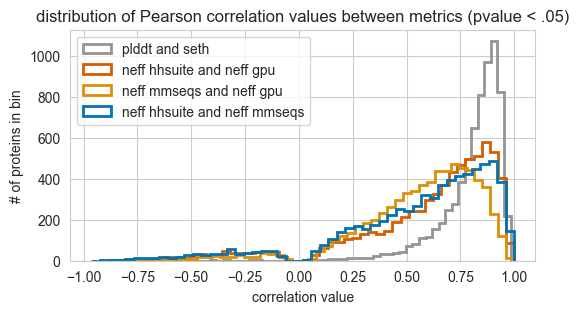

In [71]:
pairs = {
    ("plddt","seth"):colors[-3],
    ("neff hhsuite","neff gpu"):colors[3],("neff mmseqs","neff gpu"):colors[1],
    ("neff hhsuite","neff mmseqs"):colors[0],
    # ("plddt","neff hhsuite"):colors[4],("seth","neff hhsuite"):colors[6],
    # ("plddt","neff naive"):colors[2],("seth","neff naive"):colors[7],
}
plt.figure(figsize=(6,3))
pearson_corrstack = torch.stack(tuple(pearson_corrs.values()))
for i,(p,c) in enumerate(pairs.items()):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    # c=colors[i]
    plt.hist(pearson_corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=c)
#plt.axvline(0,label="no correlation",c="k",ls=":")
plt.xlabel("correlation value")
plt.ylabel("# of proteins in bin")
plt.title("distribution of Pearson correlation values between metrics (pvalue < .05)")
plt.legend(loc="upper left");

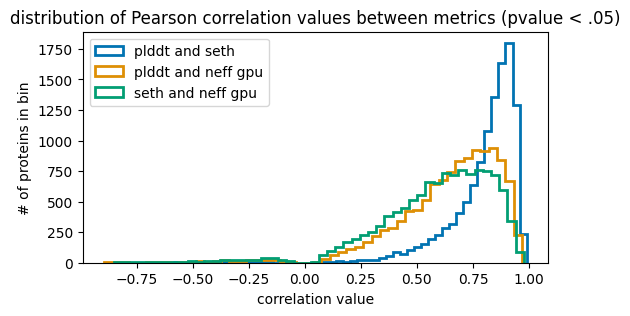

In [135]:
pairs = [("plddt","seth"),("plddt","neff gpu"),("seth","neff gpu")]
plt.figure(figsize=(6,3))
pearson_corrstack = torch.stack(tuple(pearson_corrs.values()))
for i,p in enumerate(pairs):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    plt.hist(pearson_corrstack[:,id1,id2],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=colors[i])
#plt.axvline(0,label="no correlation",c="k",ls=":")
plt.xlabel("correlation value")
plt.ylabel("# of proteins in bin")
plt.title("distribution of Pearson correlation values between metrics (pvalue < .05)")
plt.legend(loc="upper left");

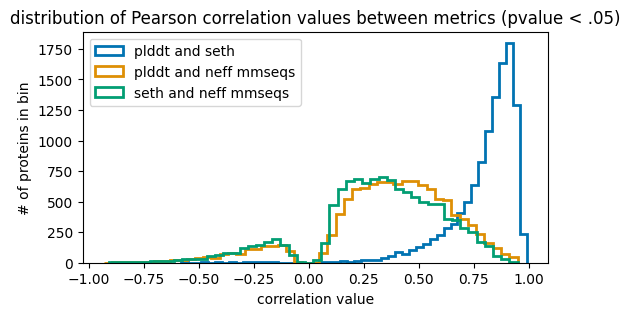

In [136]:
pairs = [("plddt","seth"),("plddt","neff mmseqs"),("seth","neff mmseqs")]
plt.figure(figsize=(6,3))
pearson_corrstack = torch.stack(tuple(pearson_corrs.values()))
for i,p in enumerate(pairs):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    plt.hist(pearson_corrstack[:,id1,id2],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=colors[i])
#plt.axvline(0,label="no correlation",c="k",ls=":")
plt.xlabel("correlation value")
plt.ylabel("# of proteins in bin")
plt.title("distribution of Pearson correlation values between metrics (pvalue < .05)")
plt.legend(loc="upper left");